# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [65]:
df= pd.read_csv('df7.csv', parse_dates=['Date'])
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df 
# len(df)

,ds,y,tby,ffr,fta,eps,div,une,vix
0,2005-06-20,1216.10,4.11,3.04,812235.0,84.81,1.76,5.0,148.30
1,2005-06-21,1213.61,4.06,3.04,812235.0,84.81,1.76,5.0,149.00
2,2005-06-22,1213.88,3.95,3.04,811179.0,84.81,1.76,5.0,148.40
3,2005-06-23,1200.73,3.96,3.04,811179.0,84.81,1.76,5.0,150.50
4,2005-06-24,1191.57,3.92,3.04,811179.0,84.81,1.76,5.0,152.00
...,...,...,...,...,...,...,...,...,...
3893,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85
3894,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30
3895,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,33.05
3896,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58,6.3,30.49


In [37]:
df.columns

Index(['ds', 'y', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'vix'], dtype='object')

In [7]:
from datetime import datetime
p = 0.9
# Train around 90% of dataset 
cutoff = int((p*len(df)//100)*100)
df_train = df[:cutoff].copy()
df_test = df.drop(df_train.index).copy()

print(df_train, df_test)

             ds        y    tby_sqsq  une_div_eps_vix_fta
0    2005-06-20  1216.10  285.343042         8.989853e+10
1    2005-06-21  1213.61  271.709069         9.032286e+10
2    2005-06-22  1213.88  243.438006         8.984219e+10
3    2005-06-23  1200.73  245.912579         9.111354e+10
4    2005-06-24  1191.57  236.126249         9.202165e+10
...         ...      ...         ...                  ...
3495 2019-06-20  2954.18   16.322408         6.065473e+10
3496 2019-06-21  2950.46   18.360368         6.235005e+10
3497 2019-06-24  2945.35   16.649664         6.137054e+10
3498 2019-06-25  2917.38   16.000000         6.287749e+10
3499 2019-06-26  2913.78   17.661006         6.207108e+10

[3500 rows x 4 columns]              ds        y   tby_sqsq  une_div_eps_vix_fta
3500 2019-06-27  2924.92  16.322408         6.038335e+10
3501 2019-06-28  2941.76  16.000000         5.888314e+10
3502 2019-07-01  2964.33  16.981817         5.581583e+10
3503 2019-07-02  2973.01  15.369536         5.32736

 Use prophet() to make predictions, we will split training as train_1 and train_2 with ratio 40% vs 60%, 
 train_1 will be used to fit prophet(), then predict on train_2.  Getting the predictions, feed the data into
 the Scenario 2 model, train again to get the parameters a,b,c,....

In [8]:
#prophet part 
from fbprophet import Prophet
start = 1000 # 1000 # the number of initial data for training 
pred_size =100 # predicted periods 
num_winds = int((df_train.shape[0]-start)/pred_size) #(4000-3000)/100 =30

pro_pred = []

# use accumulated data to predict the next pred_size data
for i in range(num_winds):
    tmp_train = df_train.iloc[: start+ i*pred_size].copy()
    
    fbp = Prophet(daily_seasonality=True)
    # fit close price using fbprophet model
    fbp.fit(tmp_train[['ds','y']])
    
    # predict pred_size futures and get the forecast price 
    fut = fbp.make_future_dataframe(periods = pred_size,)
    tmp_forecast = fbp.predict(fut) 
    
    # only require the forcast on test data of temporary training data
    pred = tmp_forecast[start+ i*pred_size:].yhat
    pro_pred.append(pred)
    

In [9]:
pro_pred

[1000    843.297510
 1001    856.104661
 1002    852.543561
 1003    832.175457
 1004    829.387909
            ...    
 1095    646.146808
 1096    643.108344
 1097    639.120987
 1098    634.852825
 1099    646.825493
 Name: yhat, Length: 100, dtype: float64,
 1100    1057.557525
 1101    1056.489569
 1102    1056.256304
 1103    1051.140526
 1104    1050.570645
            ...     
 1195    1075.234791
 1196    1078.011126
 1197    1076.818334
 1198    1075.066651
 1199    1072.741865
 Name: yhat, Length: 100, dtype: float64,
 1200    1189.913008
 1201    1187.962009
 1202    1189.605037
 1203    1194.314116
 1204    1196.617070
            ...     
 1295    1307.510030
 1296    1310.199571
 1297    1312.325702
 1298    1314.743812
 1299    1313.438237
 Name: yhat, Length: 100, dtype: float64,
 1300    1122.891480
 1301    1124.659361
 1302    1126.291339
 1303    1128.206756
 1304    1123.944392
            ...     
 1395    1184.929151
 1396    1187.265246
 1397    1196.099314
 13

In [12]:
flat_pro_pred = [item for l1 in pro_pred for item in l1]

In [42]:
df.columns

Index(['ds', 'y', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'vix'], dtype='object')

In [66]:
df['tby_sqsq'] = df['tby']**2
df['eps_sqrt'] = np.sqrt(df['eps'])
df['une_div'] =df['une'] * df['div']

df = df.drop(columns=['tby', 'ffr','eps', 'div', 'une'])

In [67]:
df.columns

Index(['ds', 'y', 'fta', 'vix', 'tby_sqsq', 'eps_sqrt', 'une_div'], dtype='object')

In [71]:
possible_features = ['fta', 'vix', 'tby_sqsq', 'eps_sqrt', 'une_div']

In [72]:
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()


In [73]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False, normalize=True, copy_X = True)
reg.fit(df_train[start:cutoff][possible_features], df_train[start:cutoff]['y'] - flat_pro_pred)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [74]:
coef = []
for i in range(len(possible_features)):
    coef.append(np.round(reg.coef_[i],5))

print(coef)

[5e-05, -17.37027, 8.56506, -15.16453, 18.72328]


In [75]:
# Forecast the Test Data
from fbprophet import Prophet
test_time = int((1-p)* len(df))
fbp = Prophet(daily_seasonality=True)
fbp.fit(df_train[['ds','y']])
fut = fbp.make_future_dataframe(periods = test_time,)
forecast = fbp.predict(fut)

pred_test = forecast[cutoff:cutoff+test_time].yhat
pred_test = pred_test.ravel()

In [76]:
len(pred_test)

389

In [77]:
pp_test = pred_test.copy() # predicted price on testing data 
pp_train = flat_pro_pred.copy() # predicted price on training data 
for i in range(len(possible_features)):
    pp_test += coef[i] * df_test[df_test.columns[i+2]][:test_time].ravel()
    pp_train += coef[i] * df_train[df_train.columns[i+2]][start:].ravel()


In [78]:
from sklearn.metrics import mean_squared_error as MSE
# MSE for test data
# Actual close price: df_test[:test_time].y 
# Predicted price by prophet: pred_test
# Predicted price by tuning 
mse1 = MSE(df_test[:test_time].y,pred_test) #
mse2 = MSE(df_test[:test_time].y, pp_test)
print(mse1,mse2)

67923.0178358458 80115.64839493162


In [79]:
# MSE for train data
mse3 = MSE(df_train[start:].y, flat_pro_pred)
mse4 = MSE(df_train[start:].y, pp_train)
print(mse3,mse4)

19362.380200429267 11267.04655844061


In [82]:
train_pred_yhat = [np.nan for i in range(start)] + flat_pro_pred
train_pp_train = [np.nan for i in range(start)] + pp_train.tolist()



In [83]:
train_date = df_train[['ds']].to_numpy().ravel()
train_date

array(['2005-06-20T00:00:00.000000000', '2005-06-21T00:00:00.000000000',
       '2005-06-22T00:00:00.000000000', ...,
       '2019-06-24T00:00:00.000000000', '2019-06-25T00:00:00.000000000',
       '2019-06-26T00:00:00.000000000'], dtype='datetime64[ns]')

In [84]:
fc_train = pd.DataFrame(data={'ds':train_date,'fbsp':train_pred_yhat, 'imsp': train_pp_train})
fc_train

,ds,fbsp,imsp
0,2005-06-20,NaN,NaN
1,2005-06-21,NaN,NaN
2,2005-06-22,NaN,NaN
3,2005-06-23,NaN,NaN
4,2005-06-24,NaN,NaN
...,...,...,...
3495,2019-06-20,3003.562802,2902.964334
3496,2019-06-21,3003.682323,2897.363961
3497,2019-06-24,3003.385785,2899.832137
3498,2019-06-25,3002.756425,2891.566040


In [85]:
m = len(forecast) -cutoff
test_pred_yhat = forecast.loc[cutoff:].yhat.copy().to_numpy().ravel()
test_date = df_test[['ds']][:m].to_numpy().ravel()

In [86]:
fc_test = pd.DataFrame(data={'ds':test_date, 'fbsp':test_pred_yhat, 'imsp': pp_test.tolist() })
fc_test

,ds,fbsp,imsp
0,2019-06-27,2937.723019,2836.264601
1,2019-06-28,2938.085533,2843.231764
2,2019-07-01,2937.566307,2856.275946
3,2019-07-02,2938.221401,2867.025529
4,2019-07-03,2938.144561,2869.935379
...,...,...,...
384,2021-01-11,3227.935727,3221.044320
385,2021-01-12,3230.042840,3237.221352
386,2021-01-13,3231.997455,3251.892861
387,2021-01-14,3232.735163,3245.777517


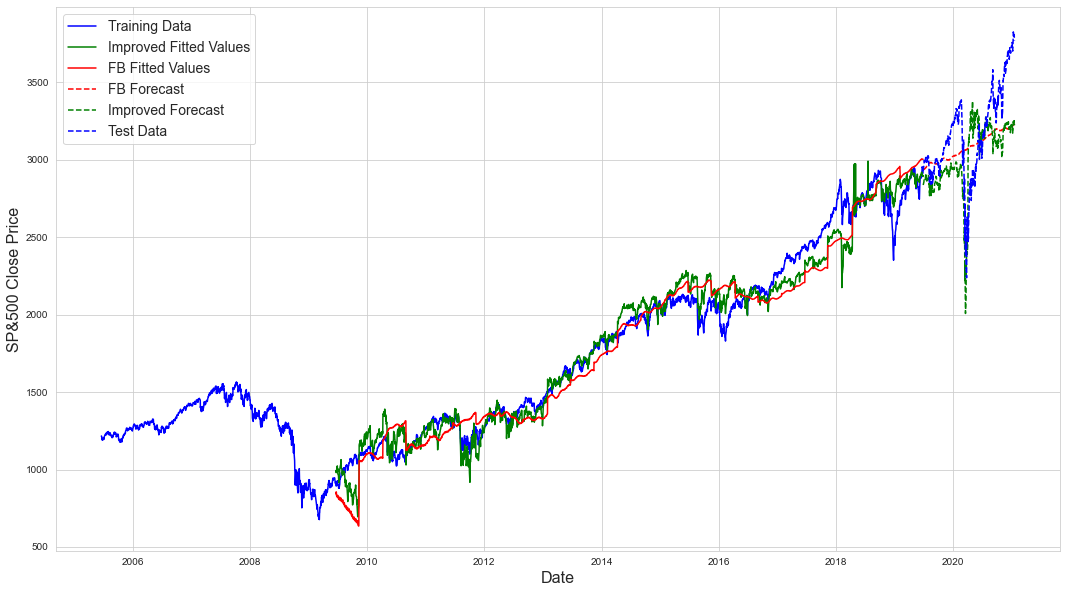

In [87]:
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

plt.plot(df_train.ds, fc_train.imsp,'g-',
            label = "Improved Fitted Values")

# plot the fit
plt.plot(df_train.ds, fc_train.fbsp,'r-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(df_test[:m].ds, fc_test.fbsp,'r--',
            label = "FB Forecast")
plt.plot(df_test[:m].ds, fc_test.imsp,'g--',
            label = "Improved Forecast")
plt.plot(df_test[:m].ds,df_test[:m].y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()